# License Plate Detection Tutorial

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/license-plate-recognition/blob/main/README.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/license-plate-recognition/blob/main/README.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="
    https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/README.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>
<br>
<br>

### Install Application Dependecies 

In [47]:
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/requirements.txt
!pip -q install -r requirements.txt

File ‘requirements.txt’ already there; not retrieving.



### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [48]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

File ‘00-start-eva-server.ipynb’ already there; not retrieving.

nohup eva_server > eva.log 2>&1 &
('01-07-2023 16:27:11 INFO  [catalog_manager:catalog_manager.py:_bootstrap_catalog:0077] Bootstrapping catalog\n', '01-07-2023 16:27:11 INFO  [base_model:base_model.py:init_db:0103] Creating tables\n', '01-07-2023 16:27:11 INFO  [timer:timer.py:log_elapsed_time:0045] Query Compile Time: 0.9859 sec\n')
('01-07-2023 16:27:11 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF FastRCNNObjectDetector already exists, nothing added.\n', '01-07-2023 16:27:11 INFO  [timer:timer.py:log_elapsed_time:0045] Query Compile Time: 0.0035 sec\n', '01-07-2023 16:27:11 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF Array_Count already exists, nothing added.\n')
('01-07-2023 16:27:11 INFO  [timer:timer.py:log_elapsed_time:0045] Query Compile Time: 0.0021 sec\n', '01-07-2023 16:27:11 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF Crop already exists, nothing

### Register OCR Extraction UDF

In [50]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/ocr_extractor.py"
cursor.execute("DROP UDF OCRExtractor;")
response = cursor.fetch_all()
print(response)
cursor.execute("""CREATE UDF IF NOT EXISTS OCRExtractor
      INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      OUTPUT (labels NDARRAY STR(ANYDIM), bboxes NDARRAY FLOAT32(ANYDIM, 4),
              scores NDARRAY FLOAT32(ANYDIM))
      TYPE  Classification
      IMPL  'ocr_extractor.py';
      """)
response = cursor.fetch_all()
print(response)

File ‘ocr_extractor.py’ already there; not retrieving.

@status: ResponseStatus.SUCCESS
@batch: 
                                        0
0  UDF OCRExtractor successfully dropped
@query_time: 0.020032875999959288
@status: ResponseStatus.SUCCESS
@batch: 
                                                       0
0  UDF OCRExtractor successfully added to the database.
@query_time: 6.00115823100009


## Download Images for License Plate Recognition

In [51]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/test_image_1.png"
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/test_image_2.png"
!wget -nc "https://raw.githubusercontent.com/femioladeji/License-Plate-Recognition-Nigerian-vehicles/master/test_images/car10.jpg"
!wget -nc "https://raw.githubusercontent.com/femioladeji/License-Plate-Recognition-Nigerian-vehicles/master/test_images/car6.jpg"
!wget -nc "https://im.ezgif.com/tmp/ezgif-1-c32008dd2a-jpg/ezgif-frame-001.jpg"

# DOWNLOAD ADDITIONAL IMAGES IF NEEDED AND LOAD THEM

#for i, plates in enumerate(car_plates):
#    for j, plate in enumerate(plates):
i=0
j=0
file_name = "frame" + str(i)+ "_plate" + str(j) + ".png"
print(file_name)
cursor.execute('DROP TABLE IF EXISTS MyImages')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD IMAGE "' + file_name + '" INTO MyImages;')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD IMAGE "test_image_1.png" INTO MyImages;')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD IMAGE "test_image_2.png" INTO MyImages;')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD IMAGE "car10.jpg" INTO MyImages;')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD IMAGE "car6.jpg" INTO MyImages;')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD IMAGE "ezgif-frame-001.jpg" INTO MyImages;')
response = cursor.fetch_all()
print(response)
cursor.execute("""SELECT OCRExtractor(data)
                FROM MyImages""")
response = cursor.fetch_all()
print(response)

File ‘test_image_1.png’ already there; not retrieving.

File ‘test_image_2.png’ already there; not retrieving.

File ‘car10.jpg’ already there; not retrieving.

File ‘car6.jpg’ already there; not retrieving.

File ‘ezgif-frame-001.jpg’ already there; not retrieving.

frame0_plate0.png
@status: ResponseStatus.SUCCESS
@batch: 
                                       0
0  Table Successfully dropped: MyImages
@query_time: 0.08128917299995919
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded IMAGE: 1
@query_time: 0.19011352999996234
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded IMAGE: 1
@query_time: 0.12077760700003637
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded IMAGE: 1
@query_time: 0.11239084700014246
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded IMAGE: 1
@query_time: 0.0729318889998467
@status: ResponseStatus.SUCC

### Annotate Model Output on Image

In [52]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt
from pathlib import Path

def annotate_image_ocr(detections, input_image_path, frame_id):
    color1=(0, 255, 150)
    color2=(255, 49, 49)
    white=(255, 255, 255)
    thickness=4

    frame = cv2.imread(input_image_path)
    height, width = frame.shape[:2]

    if frame_id == 0:
        frame= cv2.copyMakeBorder(frame, 0, 100, 0, 100, cv2.BORDER_CONSTANT,value=white)

    print(detections)
    plate_id = 0

    df = detections
    df = df[['ocrextractor.bboxes', 'ocrextractor.labels']][df.index == frame_id]

    x_offset = width * 0.2
    y_offset = height * 0.4

    if df.size:
        dfLst = df.values.tolist()
        for bbox, label in zip(dfLst[plate_id][0], dfLst[plate_id][1]):
            x1, y1, x2, y2 = bbox
            x1, y1, x2, y2 = int(x1[0]), int(x1[1]), int(x2[0]), int(x2[1])
            # object bbox
            cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 

            # object label
            # Only license plate
            if frame_id == 0:
                cv2.putText(frame, label, (int(x_offset), int(y_offset)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color2, thickness, cv2.LINE_AA) 
            # Full image
            else:
                if width < 1200:
                  cv2.putText(frame, label, (int(x_offset), int(y_offset)), cv2.FONT_HERSHEY_SIMPLEX, 3, color2, thickness, cv2.LINE_AA) 
                  y_offset = y_offset + height * 0.2
                else:
                  cv2.putText(frame, label, (int(x_offset), int(y_offset)), cv2.FONT_HERSHEY_SIMPLEX, 6, color2, thickness * 3, cv2.LINE_AA) 
                  y_offset = y_offset + height * 0.1

            # Show every  frame
            plt.imshow(frame)
            plt.show()

            p = Path(input_image_path)
            output_path = "{0}_{2}{1}".format(p.stem, p.suffix, "output")

            cv2.imwrite(output_path, frame)


                 ocrextractor.labels  \
0                        [[c017726]]   
1                     [TN-48.0.5566]   
2                   [CID, INaQ 3044]   
3                 [ISUzU, EGB-62644]   
4                  [C3UD, LEM 446a4]   
5  [@enie", 4ii982a7a|, /, 770l7726]   

                                 ocrextractor.bboxes  \
0             [[[0, 7], [84, 7], [84, 46], [0, 46]]]   
1  [[[432, 648], [723, 648], [723, 698], [432, 69...   
2  [[[310, 196], [374, 196], [374, 220], [310, 22...   
3  [[[192, 340], [286, 340], [286, 364], [192, 36...   
4  [[[259, 365], [371, 365], [371, 407], [259, 40...   
5  [[[884, 372], [978, 372], [978, 425], [884, 42...   

                                 ocrextractor.scores  
0                              [0.23887811522820945]  
1                               [0.7652641802650709]  
2           [0.2939899927886777, 0.5979598078702898]  
3          [0.14609357940751339, 0.8205176986462671]  
4         [0.05284951627254486, 0.37683438675880365

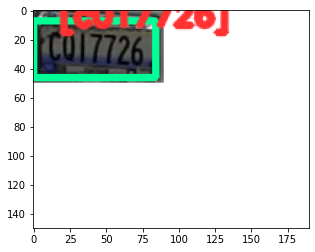

                 ocrextractor.labels  \
0                        [[c017726]]   
1                     [TN-48.0.5566]   
2                   [CID, INaQ 3044]   
3                 [ISUzU, EGB-62644]   
4                  [C3UD, LEM 446a4]   
5  [@enie", 4ii982a7a|, /, 770l7726]   

                                 ocrextractor.bboxes  \
0             [[[0, 7], [84, 7], [84, 46], [0, 46]]]   
1  [[[432, 648], [723, 648], [723, 698], [432, 69...   
2  [[[310, 196], [374, 196], [374, 220], [310, 22...   
3  [[[192, 340], [286, 340], [286, 364], [192, 36...   
4  [[[259, 365], [371, 365], [371, 407], [259, 40...   
5  [[[884, 372], [978, 372], [978, 425], [884, 42...   

                                 ocrextractor.scores  
0                              [0.23887811522820945]  
1                               [0.7652641802650709]  
2           [0.2939899927886777, 0.5979598078702898]  
3          [0.14609357940751339, 0.8205176986462671]  
4         [0.05284951627254486, 0.37683438675880365

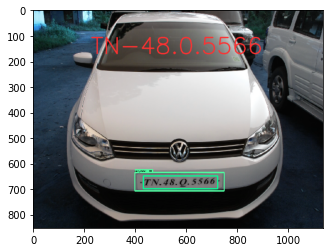

                 ocrextractor.labels  \
0                        [[c017726]]   
1                     [TN-48.0.5566]   
2                   [CID, INaQ 3044]   
3                 [ISUzU, EGB-62644]   
4                  [C3UD, LEM 446a4]   
5  [@enie", 4ii982a7a|, /, 770l7726]   

                                 ocrextractor.bboxes  \
0             [[[0, 7], [84, 7], [84, 46], [0, 46]]]   
1  [[[432, 648], [723, 648], [723, 698], [432, 69...   
2  [[[310, 196], [374, 196], [374, 220], [310, 22...   
3  [[[192, 340], [286, 340], [286, 364], [192, 36...   
4  [[[259, 365], [371, 365], [371, 407], [259, 40...   
5  [[[884, 372], [978, 372], [978, 425], [884, 42...   

                                 ocrextractor.scores  
0                              [0.23887811522820945]  
1                               [0.7652641802650709]  
2           [0.2939899927886777, 0.5979598078702898]  
3          [0.14609357940751339, 0.8205176986462671]  
4         [0.05284951627254486, 0.37683438675880365

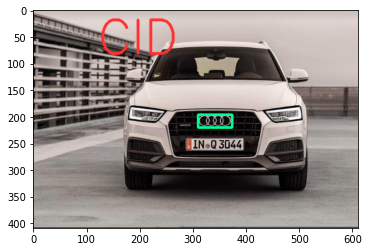

122.2
163.60000000000002


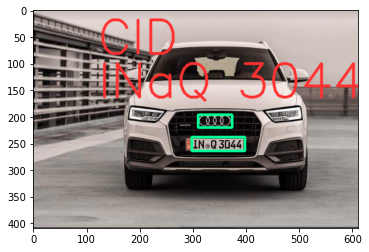

                 ocrextractor.labels  \
0                        [[c017726]]   
1                     [TN-48.0.5566]   
2                   [CID, INaQ 3044]   
3                 [ISUzU, EGB-62644]   
4                  [C3UD, LEM 446a4]   
5  [@enie", 4ii982a7a|, /, 770l7726]   

                                 ocrextractor.bboxes  \
0             [[[0, 7], [84, 7], [84, 46], [0, 46]]]   
1  [[[432, 648], [723, 648], [723, 698], [432, 69...   
2  [[[310, 196], [374, 196], [374, 220], [310, 22...   
3  [[[192, 340], [286, 340], [286, 364], [192, 36...   
4  [[[259, 365], [371, 365], [371, 407], [259, 40...   
5  [[[884, 372], [978, 372], [978, 425], [884, 42...   

                                 ocrextractor.scores  
0                              [0.23887811522820945]  
1                               [0.7652641802650709]  
2           [0.2939899927886777, 0.5979598078702898]  
3          [0.14609357940751339, 0.8205176986462671]  
4         [0.05284951627254486, 0.37683438675880365

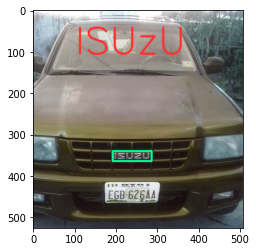

101.4
210.4


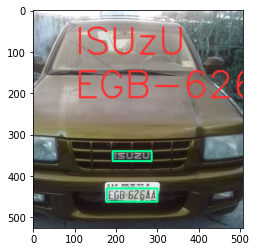

                 ocrextractor.labels  \
0                        [[c017726]]   
1                     [TN-48.0.5566]   
2                   [CID, INaQ 3044]   
3                 [ISUzU, EGB-62644]   
4                  [C3UD, LEM 446a4]   
5  [@enie", 4ii982a7a|, /, 770l7726]   

                                 ocrextractor.bboxes  \
0             [[[0, 7], [84, 7], [84, 46], [0, 46]]]   
1  [[[432, 648], [723, 648], [723, 698], [432, 69...   
2  [[[310, 196], [374, 196], [374, 220], [310, 22...   
3  [[[192, 340], [286, 340], [286, 364], [192, 36...   
4  [[[259, 365], [371, 365], [371, 407], [259, 40...   
5  [[[884, 372], [978, 372], [978, 425], [884, 42...   

                                 ocrextractor.scores  
0                              [0.23887811522820945]  
1                               [0.7652641802650709]  
2           [0.2939899927886777, 0.5979598078702898]  
3          [0.14609357940751339, 0.8205176986462671]  
4         [0.05284951627254486, 0.37683438675880365

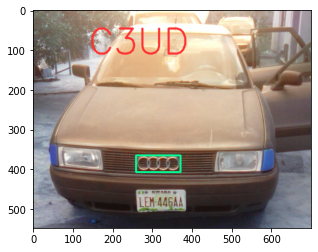

140.0
219.20000000000002


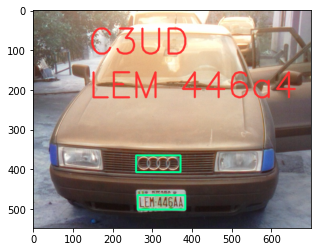

                 ocrextractor.labels  \
0                        [[c017726]]   
1                     [TN-48.0.5566]   
2                   [CID, INaQ 3044]   
3                 [ISUzU, EGB-62644]   
4                  [C3UD, LEM 446a4]   
5  [@enie", 4ii982a7a|, /, 770l7726]   

                                 ocrextractor.bboxes  \
0             [[[0, 7], [84, 7], [84, 46], [0, 46]]]   
1  [[[432, 648], [723, 648], [723, 698], [432, 69...   
2  [[[310, 196], [374, 196], [374, 220], [310, 22...   
3  [[[192, 340], [286, 340], [286, 364], [192, 36...   
4  [[[259, 365], [371, 365], [371, 407], [259, 40...   
5  [[[884, 372], [978, 372], [978, 425], [884, 42...   

                                 ocrextractor.scores  
0                              [0.23887811522820945]  
1                               [0.7652641802650709]  
2           [0.2939899927886777, 0.5979598078702898]  
3          [0.14609357940751339, 0.8205176986462671]  
4         [0.05284951627254486, 0.37683438675880365

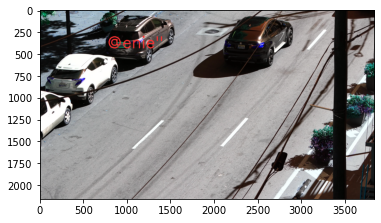

768.0
864.0


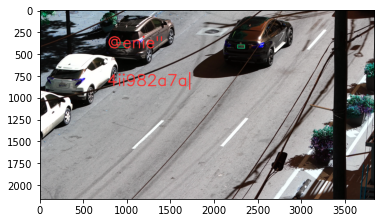

768.0
1296.0


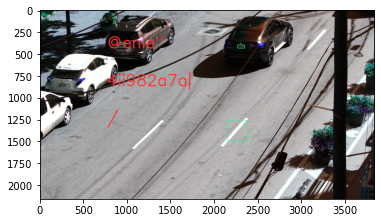

768.0
1728.0


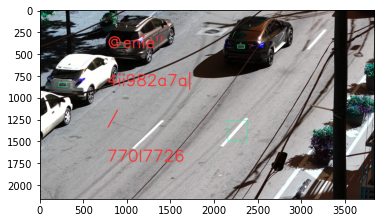

In [53]:
dataframe = response.batch.frames
annotate_image_ocr(dataframe, 'frame0_plate0.png', frame_id = 0)
annotate_image_ocr(dataframe, 'test_image_1.png', frame_id = 1)
annotate_image_ocr(dataframe, 'test_image_2.png', frame_id = 2)
annotate_image_ocr(dataframe, 'car10.jpg', frame_id = 3)
annotate_image_ocr(dataframe, 'car6.jpg', frame_id = 4)
annotate_image_ocr(dataframe, 'ezgif-frame-001.jpg', frame_id = 5)

### Create Custom UDF for Car Plate Detection

In [ ]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/car_plate_detector.py"
!wget -nc "https://www.dropbox.com/s/dl268g907vy7hxy/car_plate_detection_segmentation_model.pth"
!mv car_plate_detection_segmentation_model.pth model.pth
cursor.execute("DROP UDF IF EXISTS CarPlateDetector;")
response = cursor.fetch_all()
print(response)
cursor.execute("""CREATE UDF IF NOT EXISTS CarPlateDetector
      INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      OUTPUT (results NDARRAY FLOAT32(ANYDIM, ANYDIM))
      TYPE  Classification
      IMPL  'car_plate_detector.py';
      """) 
response = cursor.fetch_all()
print(response)

## Download Video for License Plate Recognition

In [54]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/1.mp4"
cursor.execute('DROP TABLE IF EXISTS MyVideos;')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD VIDEO "1.mp4" INTO MyVideos;')
response = cursor.fetch_all()
print(response)

File ‘1.mp4’ already there; not retrieving.

@status: ResponseStatus.SUCCESS
@batch: 
                                       0
0  Table Successfully dropped: MyVideos
@query_time: 0.082439284999964
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded VIDEO: 1
@query_time: 0.3694198729999698


### Run Car Plate Detector on Video

In [55]:
cursor.execute("""SELECT id, CarPlateDetector(data)
                  FROM MyVideos WHERE id < 1""")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
    myvideos.id  \
0            0   

                                                                              carplatedetector.results  
0  [[0 0 0 ... 0 0 0], [0 0 0 ... 0 0 0], [0 0 0 ... 0 0 0], [0 0 0 ... 0 0 0], [0 0 0 ... 0 0 0], ...  
@query_time: 8.611763949000078


### Visualize Model Output on Video

In [56]:
from pprint import pprint
from matplotlib import pyplot as plt
import cv2
import numpy as np

def annotate_video(detections, input_video_path):

    print(detections)

    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))


    # Only looking at the first frame for now
    frame_id = 0
    ret, frame = vcap.read()
    plates_in_all_frames = []

    while ret:
        df = detections
        df = df[['carplatedetector.results']][df.index == frame_id]

        if df.size:
            dfList = df.values.tolist()
            mask = np.array(dfList[0][0])
            mask = mask.astype(np.uint8)

            contours, hierarchy = cv2.findContours(
                mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

            plt.imshow(frame)
            plt.show()

            plates_within_this_frame = []
            for j, c in enumerate(contours):
                x,y,w,h = cv2.boundingRect(c)
                plate = frame[y:y+h, x:x+w]
                plates_within_this_frame.append(plate)

                image_file_name = "frame" + str(frame_id)+ "_plate" + str(j) + ".png"

                cv2.imwrite(image_file_name, plate)

                cv2.drawContours(frame, [c], 0,color2, 5)

                plt.imshow(plate)
                plt.show()

            plt.imshow(frame)
            plt.show()

            plates_in_all_frames.append(plates_within_this_frame)
            
        frame_id+=1

        ret, frame = vcap.read()

    return plates_in_all_frames


   myvideos.id                           carplatedetector.results
0            0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...


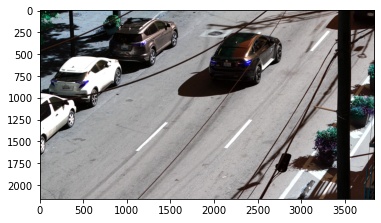

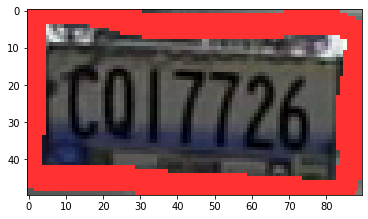

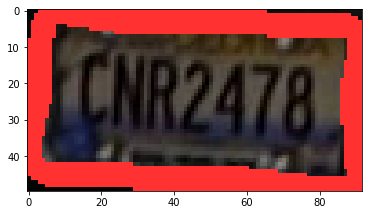

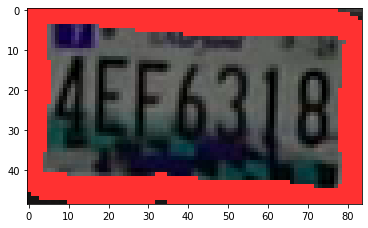

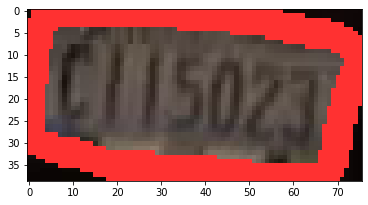

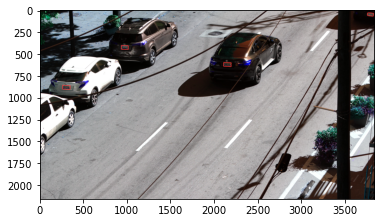

In [57]:
from ipywidgets import Video, Image
input_path = "1.mp4"
dataframe = response.batch.frames
car_plates = annotate_video(dataframe, input_path)